<a href="https://colab.research.google.com/github/DudeTheChill/tf_self_learning/blob/main/stock_market_signal_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook I'm trying to implement a deep neural network the predicts signals in the [Stock Market Data (NASDAQ, NYSE, S&P500)](https://www.kaggle.com/datasets/paultimothymooney/stock-market-data) dataset, using TensorFlow.

Importing needed Python Libraries:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from dataclasses import dataclass
import seaborn as sns

Loading the dataset into a Pandas dataframe.

In [26]:
df = pd.read_csv('AAOI.csv')
df.head(10)

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,26-09-2013,9.37,10.00,946000,10.09,9.96,9.96
1,27-09-2013,10.00,10.44,253300,10.44,10.10,10.10
2,30-09-2013,9.71,10.00,84900,10.18,10.00,10.00
3,01-10-2013,9.92,9.95,74500,10.02,10.00,10.00
4,02-10-2013,9.89,9.99,94000,10.00,9.97,9.97
5,03-10-2013,9.80,10.00,72400,10.01,10.00,10.00
6,04-10-2013,9.82,10.10,109800,10.20,10.20,10.20
7,07-10-2013,10.06,10.40,52700,10.40,10.18,10.18
8,08-10-2013,10.10,10.20,13900,10.20,10.12,10.12
9,09-10-2013,10.14,10.14,14800,10.21,10.15,10.15


Checking if the dataset contains any missing values

In [6]:
df.isna().sum()

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Low,2247.0,18.572151,1.518677e+01,1.480,9.2155,13.46,21.549999,9.715000e+01
Open,2247.0,19.099569,1.564794e+01,1.509,9.5100,13.82,22.080000,1.000000e+02
Volume,2247.0,798398.302181,1.113251e+06,7100.000,251000.0000,477200.00,856400.000000,1.703530e+07
High,2247.0,19.619143,1.611180e+01,1.560,9.7725,14.17,22.758000,1.034100e+02
Close,2247.0,19.094377,1.565836e+01,1.500,9.4950,13.84,22.105000,9.961000e+01
Adjusted Close,2247.0,19.094377,1.565836e+01,1.500,9.4950,13.84,22.105000,9.961000e+01


Plotting the pairplot of all singlas

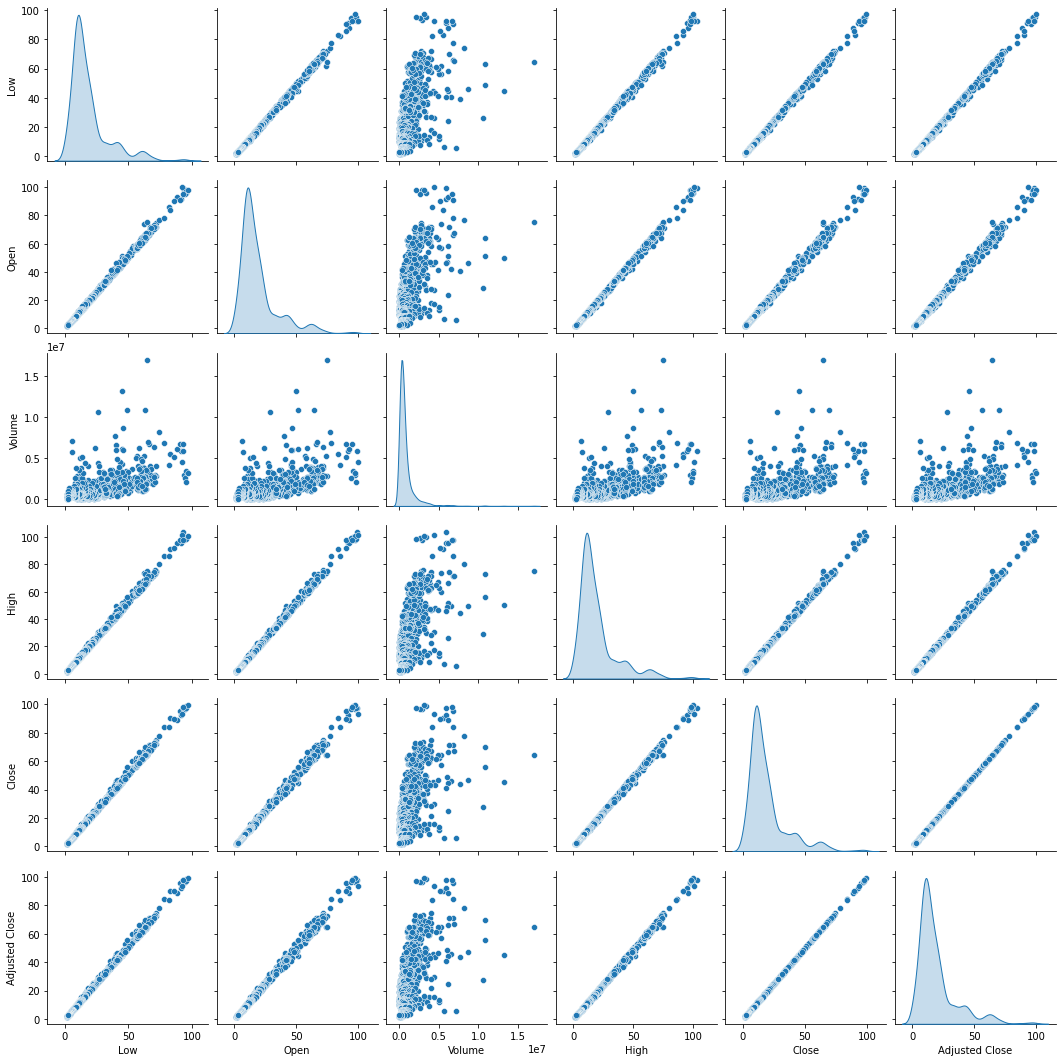

In [8]:
sns.pairplot(df, diag_kind='kde')

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [12]:
df.shape[1]

7

In [15]:
@dataclass
class Params:
    TIME = range(df.shape[0])
    SERIES = df['Close']
    SPLIT_TIME = 2000
    WINDOW_SIZE = 5
    BATCH_SIZE = 10
    SHUFFLE_BUFFER_SIZE = 6

In [16]:
def train_val_split(time, series, time_step=Params.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(Params.TIME, Params.SERIES)

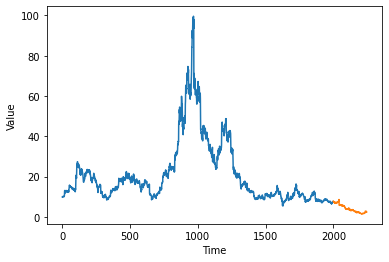

In [17]:
plot_series(time_train, series_train)
plot_series(time_valid, series_valid)

In [18]:
def windowed_dataset(series, window_size=Params.WINDOW_SIZE, batch_size=Params.BATCH_SIZE, shuffle_buffer=Params.SHUFFLE_BUFFER_SIZE):

    ### START CODE HERE

    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)

    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)

    ### END CODE HERE

    return dataset

In [19]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


In [20]:
def create_model(window_size=Params.WINDOW_SIZE):

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.Adam())

    ### END CODE HERE

    return model

In [21]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
#if you want to change the model, uncomment this line
model = create_model()

# Train it
#if you want to change the model, uncomment this line
model.fit(dataset, epochs=100)

#if you want to change the model, comment this line
#model = tf.keras.models.load_model("my_model.h5")

Epoch 1/100
200/200 [==============================] - 2s 4ms/step - loss: 175.7315
Epoch 2/100
200/200 [==============================] - 1s 3ms/step - loss: 4.4770
Epoch 3/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8340
Epoch 4/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8621
Epoch 5/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8671
Epoch 6/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8570
Epoch 7/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8957
Epoch 8/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8862
Epoch 9/100
200/200 [==============================] - 1s 3ms/step - loss: 3.9186
Epoch 10/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8834
Epoch 11/100
200/200 [==============================] - 1s 3ms/step - loss: 3.8403
Epoch 12/100
200/200 [==============================] - 1s 3ms/step - loss: 3.9457
Epoch 13/10

In [22]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

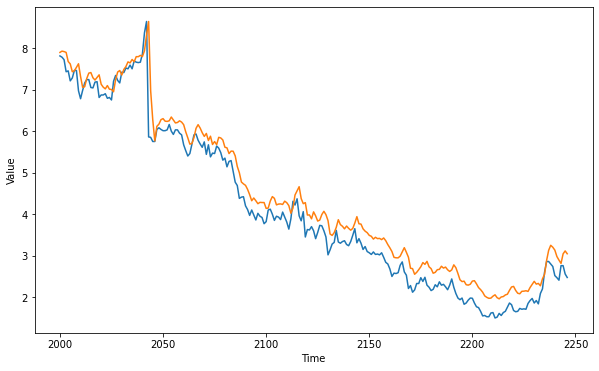

In [23]:
def generate_forecast(series=Params.SERIES.to_numpy(), split_time=Params.SPLIT_TIME, window_size=Params.WINDOW_SIZE):
    forecast = []
    for time in range((len(series) - window_size)):
        prediction = model.predict(series[time:time + window_size][np.newaxis])
        forecast.append(prediction)
        print(time)

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

In [25]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 0.18, mae: 0.36 for forecast
